In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import datetime
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Input, LSTM
from keras.models import Sequential, Model,load_model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Input, Convolution1D, MaxPooling1D, GlobalMaxPooling1D
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import datetime
import pickle

Using TensorFlow backend.


In [2]:
final_agg_data=pd.read_csv("stores_agg.csv")

In [3]:
final_agg_data.drop("transactions",inplace=True,axis=1)

In [4]:
y1 = torch.tensor(final_agg_data['unit_sales'].values.astype(np.float32))
X1 = torch.tensor(final_agg_data.drop('unit_sales', axis = 1).values.astype(np.float32)) 
dataset1 = TensorDataset(X1,y1) 

In [5]:
train_set1, val_set1 = torch.utils.data.random_split(dataset1, [66488, 16622],)
train_loader1 = DataLoader(dataset = train_set1, shuffle = True,batch_size=16)

In [6]:
validation_loader1=DataLoader(dataset = val_set1, shuffle = True,batch_size=16622)

In [7]:
for i,j in validation_loader1:
    X_test1,y_test1=i,j

### Subset data

In [8]:
y1 = torch.tensor(final_agg_data['unit_sales'].values.astype(np.float32))[:4500]
X1 = torch.tensor(final_agg_data.drop('unit_sales', axis = 1).values.astype(np.float32))[:4500] 
dataset1 = TensorDataset(X1,y1) 

In [9]:
train_set1, val_set1 = torch.utils.data.random_split(dataset1, [4000,500])
train_loader1 = DataLoader(dataset = train_set1, shuffle = True,batch_size=16)

In [10]:
validation_loader1=DataLoader(dataset = val_set1, shuffle = True,batch_size=500)

In [11]:
for i,j in validation_loader1:
    X_test1,y_test1=i,j

### Model 

In [17]:
class FirstNetwork_v1(nn.Module):
    def __init__(self,number_of_nodes):
        super().__init__()
        self.lin1 = nn.Linear(83,number_of_nodes)
        self.lin2 = nn.Linear(number_of_nodes, 1)
    
    def forward(self, X):
        a1 = self.lin1(X)
        h1 = a1.relu()
        a2 = self.lin2(h1)
        return a2,a1

In [18]:
device = torch.device("cuda:0")

In [19]:
all_models_train_loss={}
all_models_val_loss={}
all_models_time={}

In [20]:
for i in range(15,41,5):
    print("Running Model with "+str(i)," nodes")
    all_models_train_loss[i]=[]
    all_models_val_loss[i]=[] 
    all_models_time[i]=[]
    for p in range(10):
#         torch.manual_seed(np.random.randint(0,1000000,1))
#         train_set1, val_set1 = torch.utils.data.random_split(dataset1, [4000,500])
#         train_loader1 = DataLoader(dataset = train_set1, shuffle = True,batch_size=16)
#         validation_loader1=DataLoader(dataset = val_set1, shuffle = True,batch_size=500)
        for c,v in validation_loader1:
            X_test1,y_test1=c,v
        print(str(p)+" Times Model Repeated")
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        model1=FirstNetwork_v1(number_of_nodes=i).to(device)
        criterion1 = nn.MSELoss()
        training_loss_model1=[]
        validation_loss_model1=[]
        time_model1=[]
        epochs = 100
        optimizer1 = optim.SGD(model1.parameters(), lr=0.01)
        for epoch in range(epochs):
            training_loss_batch=[]
            validation_loss_batch=[]
            time_batch=[]
            for X_train, y_train in train_loader1:
                model1.train()
                optimizer1.zero_grad()
                X_train,y_train=X_train.to(device),y_train.to(device)
                start.record()
                output,features = model1(X_train)
                loss1 = criterion1(output, y_train.reshape(-1,1))
                loss1.backward()
                optimizer1.step()
                end.record()
                training_loss_batch.append(loss1.item())
                model1.eval()
                validation_loss_batch.append(criterion1(model1(X_test1.to(device))[0],y_test1.to(device).reshape(-1,1)).item())
                time_batch.append(start.elapsed_time(end))
            training_loss_model1.append(training_loss_batch)
            validation_loss_model1.append(validation_loss_batch)
            time_model1.append(time_batch)
        del model1
        torch.cuda.empty_cache()
        all_models_val_loss[i].append(validation_loss_model1)
        all_models_train_loss[i].append(training_loss_model1)
        all_models_time[i].append(time_model1)

Running Model with 15  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 20  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 25  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 30  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Mo

In [21]:
with open('store_model_train_sub.p', 'wb') as fp:
    pickle.dump(all_models_train_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('store_model_val_sub.p', 'wb') as fp:
    pickle.dump(all_models_val_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('store_model_time_sub.p', 'wb') as fp:
    pickle.dump(all_models_time, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
for m in sorted(all_models_val_loss.keys()):
    print(m,np.mean([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]),
         np.std([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]))

15 0.0006706327103311197 8.873485486296187e-05
20 0.0005945751896593719 3.882718091821089e-05
25 0.0006343823679955676 6.044432135587443e-05
30 0.0005887161928927525 0.000102450483857153
35 0.0005606920357095077 3.426764732307398e-05
40 0.0005674828005954623 4.643754637914265e-05


In [23]:
all_models_train_loss={}
all_models_val_loss={}
all_models_time={}

In [24]:
for i in range(25,26,5):
    print("Running Model with "+str(i)," nodes")
    all_models_train_loss[i]=[]
    all_models_val_loss[i]=[] 
    all_models_time[i]=[]
    for p in range(10):
        #torch.manual_seed(np.random.randint(0,1000000,1))
#         train_set1, val_set1 = torch.utils.data.random_split(dataset1, [4000,500])
#         train_loader1 = DataLoader(dataset = train_set1, shuffle = True,batch_size=16)
#         validation_loader1=DataLoader(dataset = val_set1, shuffle = True,batch_size=500)
        for c,v in validation_loader1:
            X_test1,y_test1=c,v
        print(str(p)+" Times Model Repeated")
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        model1=FirstNetwork_v1(number_of_nodes=i).to(device)
        criterion1 = nn.MSELoss()
        training_loss_model1=[]
        validation_loss_model1=[]
        time_model1=[]
        epochs = 100
        optimizer1 = optim.Adam(model1.parameters(), lr=0.01)
        for epoch in range(epochs):
            training_loss_batch=[]
            validation_loss_batch=[]
            time_batch=[]
            for X_train, y_train in train_loader1:
                model1.train()
                optimizer1.zero_grad()
                X_train,y_train=X_train.to(device),y_train.to(device)
                start.record()
                output,features = model1(X_train)
                loss1 = criterion1(output, y_train.reshape(-1,1))
                loss1.backward()
                optimizer1.step()
                end.record()
                training_loss_batch.append(loss1.item())
                model1.eval()
                validation_loss_batch.append(criterion1(model1(X_test1.to(device))[0],y_test1.to(device).reshape(-1,1)).item())
                time_batch.append(start.elapsed_time(end))
            training_loss_model1.append(training_loss_batch)
            validation_loss_model1.append(validation_loss_batch)
            time_model1.append(time_batch)
        del model1
        torch.cuda.empty_cache()
        all_models_val_loss[i].append(validation_loss_model1)
        all_models_train_loss[i].append(training_loss_model1)
        all_models_time[i].append(time_model1)

Running Model with 25  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated


In [25]:
with open('store_model_train_sub1.p', 'wb') as fp:
    pickle.dump(all_models_train_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
with open('store_model_val_sub1.p', 'wb') as fp:
    pickle.dump(all_models_val_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
with open('store_model_time_sub1.p', 'wb') as fp:
    pickle.dump(all_models_time, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
time_list=[]
for y in range(10):
    min_arg=np.argmin([np.mean(all_models_time[25][y][i]) for i in range(len(all_models_time[25][y]))])
    time_list.append(np.cumsum([sum(all_models_time[25][y][i]) for i in range(len(all_models_time[25][y]))][:min_arg])[-1])

In [29]:
np.mean(time_list)

29500.5981136322

In [30]:
for m in sorted(all_models_val_loss.keys()):
    print(m,np.mean([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]),
         np.std([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]))

25 0.00034839822872309014 1.1648447180425292e-05


In [31]:
y1 = torch.tensor(final_agg_data['unit_sales'].values.astype(np.float32))[:4500]
X1 = torch.tensor(final_agg_data.drop('unit_sales', axis = 1).values.astype(np.float32))[:4500]
dataset1 = TensorDataset(X1,y1) 

train_set1, val_set1 = torch.utils.data.random_split(dataset1, [4000, 500],)
train_loader1 = DataLoader(dataset = train_set1, shuffle = True,batch_size=32)

validation_loader1=DataLoader(dataset = val_set1, shuffle = True,batch_size=500)

for i,j in validation_loader1:
    X_test1,y_test1=i,j

In [32]:
all_models_train_loss={}
all_models_val_loss={}
all_models_time={}

for i in range(20,41,5):
    print("Running Model with "+str(i)," nodes")
    all_models_train_loss[i]=[]
    all_models_val_loss[i]=[] 
    all_models_time[i]=[]
    for p in range(10):
        #torch.manual_seed(np.random.randint(0,1000000,1))
#         train_set1, val_set1 = torch.utils.data.random_split(dataset1, [4000,500])
#         train_loader1 = DataLoader(dataset = train_set1, shuffle = True,batch_size=16)
#         validation_loader1=DataLoader(dataset = val_set1, shuffle = True,batch_size=500)
        for c,v in validation_loader1:
            X_test1,y_test1=c,v
        print(str(p)+" Times Model Repeated")
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        model1=FirstNetwork_v1(number_of_nodes=i).to(device)
        criterion1 = nn.MSELoss()
        training_loss_model1=[]
        validation_loss_model1=[]
        time_model1=[]
        epochs = 100
        optimizer1 = optim.Adam(model1.parameters(), lr=0.01)
        for epoch in range(epochs):
            training_loss_batch=[]
            validation_loss_batch=[]
            time_batch=[]
            for X_train, y_train in train_loader1:
                model1.train()
                optimizer1.zero_grad()
                X_train,y_train=X_train.to(device),y_train.to(device)
                start.record()
                output,features = model1(X_train)
                loss1 = criterion1(output, y_train.reshape(-1,1))
                loss1.backward()
                optimizer1.step()
                end.record()
                training_loss_batch.append(loss1.item())
                model1.eval()
                validation_loss_batch.append(criterion1(model1(X_test1.to(device))[0],y_test1.to(device).reshape(-1,1)).item())
                time_batch.append(start.elapsed_time(end))
            training_loss_model1.append(training_loss_batch)
            validation_loss_model1.append(validation_loss_batch)
            time_model1.append(time_batch)
        del model1
        torch.cuda.empty_cache()
        all_models_val_loss[i].append(validation_loss_model1)
        all_models_train_loss[i].append(training_loss_model1)
        all_models_time[i].append(time_model1)

Running Model with 20  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 25  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 30  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Model Repeated
9 Times Model Repeated
Running Model with 35  nodes
0 Times Model Repeated
1 Times Model Repeated
2 Times Model Repeated
3 Times Model Repeated
4 Times Model Repeated
5 Times Model Repeated
6 Times Model Repeated
7 Times Model Repeated
8 Times Mo

In [33]:
with open('store_model_train_sub2.p', 'wb') as fp:
    pickle.dump(all_models_train_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('store_model_val_sub2.p', 'wb') as fp:
    pickle.dump(all_models_val_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)

with open('store_model_time_sub2.p', 'wb') as fp:
    pickle.dump(all_models_time, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
for m in sorted(all_models_val_loss.keys()):
    print(m,np.mean([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]),
         np.std([min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]))

20 0.0004994891935959459 3.117174955118241e-05
25 0.0004734137291554362 3.952852312891622e-05
30 0.0004859088379424065 5.090764519826238e-05
35 0.0004922704371158034 3.380633383850725e-05
40 0.0004949642788851633 2.6035526032642234e-05


In [35]:
with open(r"store_model_val_sub.p", "rb") as input_file:
    all_models_val_loss= pickle.load(input_file)

item_model_loss={}

for m in sorted(all_models_val_loss.keys()):
        item_model_loss[m]=[min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]

In [36]:
with open(r"store_model_val_sub1.p", "rb") as input_file:
    all_models_val_loss= pickle.load(input_file)

item_model_loss1={}

for m in sorted(all_models_val_loss.keys()):
        item_model_loss1[m]=[min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]

In [37]:
with open(r"store_model_val_sub2.p", "rb") as input_file:
    all_models_val_loss= pickle.load(input_file)

item_model_loss2={}

for m in sorted(all_models_val_loss.keys()):
        item_model_loss2[m]=[min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]

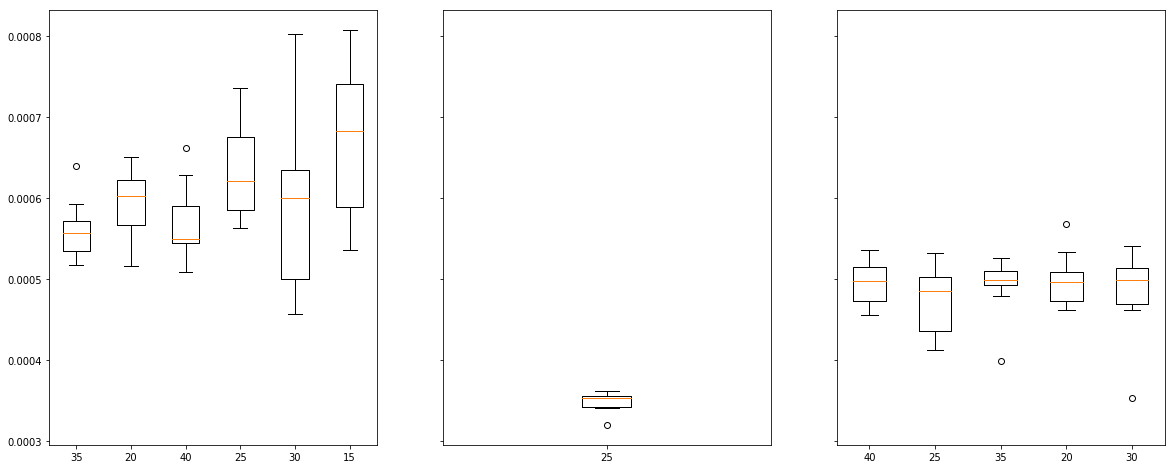

In [38]:
fig, ax = plt.subplots(1,3,figsize=(20,8),sharey=True)
ax[0].boxplot(item_model_loss.values(),labels=item_model_loss.keys())
ax[1].boxplot(item_model_loss1.values(),labels=item_model_loss1.keys())
ax[2].boxplot(item_model_loss2.values(),labels=item_model_loss2.keys());

In [39]:
with open(r"store_model_time_sub2.p", "rb") as input_file:
    all_models_val_loss= pickle.load(input_file)

item_model_loss1={}

for m in sorted(all_models_val_loss.keys()):
        item_model_loss1[m]=[min([np.mean(all_models_val_loss[m][k][i]) for i in range(len(all_models_val_loss[m][k]))]) for k in range(len(all_models_val_loss[m]))]

In [40]:
item_model_loss1[25]

[2.910198522567749,
 2.922741502761841,
 2.88907928276062,
 2.9271982135772707,
 2.9103477725982665,
 2.9183098773956297,
 2.916229621887207,
 2.9138618698120116,
 2.9096596508026122,
 2.893749755859375]

### Final Model

In [41]:
y1 = torch.tensor(final_agg_data['unit_sales'].values.astype(np.float32))
X1 = torch.tensor(final_agg_data.drop('unit_sales', axis = 1).values.astype(np.float32)) 
dataset1 = TensorDataset(X1,y1) 

train_set1, val_set1 = torch.utils.data.random_split(dataset1, [66488, 16622],)
train_loader1 = DataLoader(dataset = train_set1, shuffle = True,batch_size=16)

validation_loader1=DataLoader(dataset = val_set1, shuffle = True,batch_size=16622)

for i,j in validation_loader1:
    X_test1,y_test1=i,j

In [42]:
class FirstNetwork_final(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.lin1 = nn.Linear(83,25)
        self.lin2 = nn.Linear(25, 1)
    
    def forward(self, X):
        a1 = self.lin1(X)
        h1 = a1.relu()
        a2 = self.lin2(h1)
        return a2,a1

In [43]:
model1=FirstNetwork_final()

In [44]:
criterion1 = nn.MSELoss()

training_loss_model1=[]
validation_loss_model1=[]

epochs = 40
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)

for epoch in range(epochs):
    training_loss_batch=[]
    validation_loss_batch=[]
    for X_train, y_train in train_loader1:
        model1.train()
        optimizer1.zero_grad()
        output,features = model1(X_train)
        loss1 = criterion1(output, y_train.reshape(-1,1))
        loss1.backward()
        optimizer1.step()
        training_loss_batch.append(loss1.item())
        model1.eval()
        validation_loss_batch.append(criterion1(model1(X_test1)[0],y_test1.reshape(-1,1)).item())
    validation_loss_model1.append(validation_loss_batch)
    training_loss_model1.append(training_loss_batch)
    if epoch%10==0:
        print(epoch)
        print("Training Loss:",np.mean(training_loss_batch))
        print("Validation Loss:",np.mean(validation_loss_batch))

0
Training Loss: 0.0005937622772298613
Validation Loss: 0.0005488837452260155
10
Training Loss: 0.0005307834128015814
Validation Loss: 0.00048798109912225003
20
Training Loss: 0.000539958095696884
Validation Loss: 0.0004973362102104361
30
Training Loss: 0.0005358810311926084
Validation Loss: 0.0004984814802878712


In [45]:
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

for epoch in range(40,140):
    training_loss_batch=[]
    validation_loss_batch=[]
    for X_train, y_train in train_loader1:
        model1.train()
        optimizer1.zero_grad()
        output,features = model1(X_train)
        loss1 = criterion1(output, y_train.reshape(-1,1))
        loss1.backward()
        optimizer1.step()
        training_loss_batch.append(loss1.item())
        model1.eval()
        validation_loss_batch.append(criterion1(model1(X_test1)[0],y_test1.reshape(-1,1)).item())
    validation_loss_model1.append(validation_loss_batch)
    training_loss_model1.append(training_loss_batch)
    if epoch%10==0:
        print(epoch)
        print("Training Loss:",np.mean(training_loss_batch))
        print("Validation Loss:",np.mean(validation_loss_batch))

40
Training Loss: 0.00041670804667275985
Validation Loss: 0.0003705873554092348
50
Training Loss: 0.0004103782580456934
Validation Loss: 0.00036635024500830383
60
Training Loss: 0.00040948702737490447
Validation Loss: 0.00036463019897838825
70
Training Loss: 0.00040972938838813405
Validation Loss: 0.0003653913554059287
80
Training Loss: 0.0004111796339050244
Validation Loss: 0.0003662864031861523
90
Training Loss: 0.0004099144978863653
Validation Loss: 0.00036555995756525615
100
Training Loss: 0.00040946170592982985
Validation Loss: 0.0003645406403645821
110
Training Loss: 0.00041041027444627234
Validation Loss: 0.0003641856148307565
120
Training Loss: 0.0004100396466560137
Validation Loss: 0.0003651991240735456
130
Training Loss: 0.00041011266612442447
Validation Loss: 0.00036500573345492267


In [46]:
optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)

for epoch in range(140,180):
    training_loss_batch=[]
    validation_loss_batch=[]
    for X_train, y_train in train_loader1:
        model1.train()
        optimizer1.zero_grad()
        output,features = model1(X_train)
        loss1 = criterion1(output, y_train.reshape(-1,1))
        loss1.backward()
        optimizer1.step()
        training_loss_batch.append(loss1.item())
        model1.eval()
        validation_loss_batch.append(criterion1(model1(X_test1)[0],y_test1.reshape(-1,1)).item())
    validation_loss_model1.append(validation_loss_batch)
    training_loss_model1.append(training_loss_batch)
    if epoch%10==0:
        print(epoch)
        print("Training Loss:",np.mean(training_loss_batch))
        print("Validation Loss:",np.mean(validation_loss_batch))

140
Training Loss: 0.00039874573577007463
Validation Loss: 0.0003546733622949237
150
Training Loss: 0.0003979502398688335
Validation Loss: 0.00035380173512897836
160
Training Loss: 0.0003981540647385148
Validation Loss: 0.0003535072512838284
170
Training Loss: 0.00039835251999787065
Validation Loss: 0.0003533483893068012


In [47]:
optimizer1 = optim.Adam(model1.parameters(), lr=0.00001)

for epoch in range(180,210):
    training_loss_batch=[]
    validation_loss_batch=[]
    for X_train, y_train in train_loader1:
        model1.train()
        optimizer1.zero_grad()
        output,features = model1(X_train)
        loss1 = criterion1(output, y_train.reshape(-1,1))
        loss1.backward()
        optimizer1.step()
        training_loss_batch.append(loss1.item())
        model1.eval()
        validation_loss_batch.append(criterion1(model1(X_test1)[0],y_test1.reshape(-1,1)).item())
    validation_loss_model1.append(validation_loss_batch)
    training_loss_model1.append(training_loss_batch)
    if epoch%10==0:
        print(epoch)
        print("Training Loss:",np.mean(training_loss_batch))
        print("Validation Loss:",np.mean(validation_loss_batch))

180
Training Loss: 0.00039700646394610163
Validation Loss: 0.0003532861326069883
190
Training Loss: 0.0003967019753357882
Validation Loss: 0.0003525075548128122
200
Training Loss: 0.0003966664006715557
Validation Loss: 0.000352504033200307


In [48]:
optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)

for epoch in range(210,240):
    training_loss_batch=[]
    validation_loss_batch=[]
    for X_train, y_train in train_loader1:
        model1.train()
        optimizer1.zero_grad()
        output,features = model1(X_train)
        loss1 = criterion1(output, y_train.reshape(-1,1))
        loss1.backward()
        optimizer1.step()
        training_loss_batch.append(loss1.item())
        model1.eval()
        validation_loss_batch.append(criterion1(model1(X_test1)[0],y_test1.reshape(-1,1)).item())
    validation_loss_model1.append(validation_loss_batch)
    training_loss_model1.append(training_loss_batch)
    if epoch%10==0:
        print(epoch)
        print("Training Loss:",np.mean(training_loss_batch))
        print("Validation Loss:",np.mean(validation_loss_batch))

210
Training Loss: 0.00039801248281330507
Validation Loss: 0.0003534686591004378
220
Training Loss: 0.00039836232849250184
Validation Loss: 0.00035328564266683186
230
Training Loss: 0.00039792265793551487
Validation Loss: 0.0003534061486454756


In [49]:
torch.save(model1.state_dict(), "stores_model_final.pt")